In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math
import re
import seaborn as sns
from surprise import Reader, Dataset, SVD, evaluate
sns.set_style("darkgrid")
import os
import time
import gc
import warnings
warnings.filterwarnings('ignore')

In [111]:
# Date not needed

netflix_df2 = pd.read_csv('few_samples_netflix.csv')

netflix_df2['rating'] = netflix_df2['rating'].astype(float)

print('Dataset 2 shape: {}'.format(netflix_df2.shape))
print('-Dataset examples-')
print(netflix_df2.iloc[::50000, :])

netflix_df2.head(5)

Dataset 2 shape: (514358, 3)
-Dataset examples-
        movie_id  user_id  rating
0              1   729846     4.0
50000       1905   517358     3.0
100000      3713  2154387     3.0
150000      5345  2226039     3.0
200000      6930   798248     5.0
250000      8782  2093597     5.0
300000     10730  1415809     4.0
350000     12376  1962698     4.0
400000     14203  2004709     3.0
450000     15582   934318     5.0
500000     17295  1175759     2.0


,movie_id,user_id,rating
0,1,729846,4.0
1,1,915,5.0
2,1,1839976,2.0
3,1,1682651,4.0
4,1,1140108,4.0


In [112]:
netflix_movie_titles_df5 = pd.read_csv('movie_titles.txt', delimiter='\t', header=None)
#netflix_movie_titles_df5.drop(['Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5'], axis =1)
netflix_movie_titles_df5 = netflix_movie_titles_df5.iloc[:, 0:3]
netflix_movie_titles_df5.columns = ['movie_id', 'year', 'movie_title']
netflix_movie_titles_df5['year'] = netflix_movie_titles_df5['year']
netflix_movie_titles_df5.head(5)

,movie_id,year,movie_title
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW


In [113]:
full_netflix_data = pd.merge(netflix_df2, netflix_movie_titles_df5, on='movie_id')
full_netflix_data.head(5)

,movie_id,user_id,rating,year,movie_title
0,1,729846,4.0,2003.0,Dinosaur Planet
1,1,915,5.0,2003.0,Dinosaur Planet
2,1,1839976,2.0,2003.0,Dinosaur Planet
3,1,1682651,4.0,2003.0,Dinosaur Planet
4,1,1140108,4.0,2003.0,Dinosaur Planet


In [114]:
# Lets see what we have here 
full_netflix_data.describe()['rating']

count    514358.000000
mean          3.600811
std           1.074233
min           1.000000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

In [115]:
print("Number of NaN values in Netflix dataframe : ", sum(full_netflix_data.isnull().any()))

Number of NaN values in Netflix dataframe :  0


In [116]:
duplicates = full_netflix_data.duplicated(['movie_id','user_id','rating'])
dups = sum(duplicates) # by considering all columns..( including timestamp)
print("There are {} duplicate rating entries in the data.".format(dups))

There are 0 duplicate rating entries in the data.


In [117]:
print("Total data ")
print("-"*50)
print("\nTotal number of ratings :",full_netflix_data.shape[0])
print("Total number of users   :", len(np.unique(full_netflix_data.user_id)))
print("Total number of movies  :", len(np.unique(full_netflix_data.movie_id)))

Total data 
--------------------------------------------------

Total number of ratings : 514358
Total number of users   : 1934
Total number of movies  : 11855


In [118]:
print('Full Netflix dataset shape: {}'.format(full_netflix_data.shape))
print('---Dataset examples---')
print(full_netflix_data.iloc[::50000, :])

full_netflix_data.head(5)

Full Netflix dataset shape: (514358, 5)
---Dataset examples---
        movie_id  user_id  rating    year  \
0              1   729846     4.0  2003.0   
50000       1905   517358     3.0  2003.0   
100000      3713  2154387     3.0  2004.0   
150000      5345  2226039     3.0  2004.0   
200000      6930   798248     5.0  2001.0   
250000      8782  2093597     5.0  2001.0   
300000     10730  1415809     4.0  2002.0   
350000     12376  1962698     4.0  1988.0   
400000     14203  2004709     3.0  1995.0   
450000     15582   934318     5.0  2002.0   
500000     17295  1175759     2.0  2000.0   

                                              movie_title  
0                                         Dinosaur Planet  
50000   Pirates of the Caribbean: The Curse of the Bla...  
100000                                                Saw  
150000                                         Shark Tale  
200000                              The Safety of Objects  
250000                              

,movie_id,user_id,rating,year,movie_title
0,1,729846,4.0,2003.0,Dinosaur Planet
1,1,915,5.0,2003.0,Dinosaur Planet
2,1,1839976,2.0,2003.0,Dinosaur Planet
3,1,1682651,4.0,2003.0,Dinosaur Planet
4,1,1140108,4.0,2003.0,Dinosaur Planet


In [119]:
# play with quartile because it may affect model accuracy

count_mean_vars = ['count', 'mean']

movie_summary_df = full_netflix_data.groupby('movie_id')['rating'].agg(count_mean_vars)
movie_summary_df.index = movie_summary_df.index.map(int)
movie_benchmark = round(movie_summary_df['count'].quantile(0.70), 0)
movie_list_benchmark_drop = movie_summary_df[movie_summary_df['count'] < movie_benchmark].index

print('Minimum number of times movies were reviewed: {}'.format(movie_benchmark))

customer_summary_df = full_netflix_data.groupby('user_id')['rating'].agg(count_mean_vars)
customer_summary_df.index = customer_summary_df.index.map(int)
customer_benchmark = round(customer_summary_df['count'].quantile(0.70), 0)
customer_list_benchmark_drop = customer_summary_df[customer_summary_df['count'] < customer_benchmark].index

print('Minimum number of times customers reviewed movies: {}'.format(customer_benchmark))

Minimum number of times movies were reviewed: 21.0
Minimum number of times customers reviewed movies: 287.0


In [167]:
#clean up NaN's
full_netflix_data_dummy = full_netflix_data.copy().fillna(0)

full_netflix_data_dummy.head(10)


,movie_id,user_id,rating,year,movie_title
0,1,729846,4.0,2003.0,Dinosaur Planet
1,1,915,5.0,2003.0,Dinosaur Planet
2,1,1839976,2.0,2003.0,Dinosaur Planet
3,1,1682651,4.0,2003.0,Dinosaur Planet
4,1,1140108,4.0,2003.0,Dinosaur Planet
5,3,1644750,3.0,1997.0,Character
6,3,376148,5.0,1997.0,Character
7,3,1956967,4.0,1997.0,Character
8,3,2095263,4.0,1997.0,Character
9,3,665242,2.0,1997.0,Character


In [121]:
export_csv_netflix_full_movie = full_netflix_data_dummy.to_csv (r'C:\Users\AaronDataScienceComp\Documents\export_data_netflix_full_movies.csv', index = None, header=True)

export_csv_netflix_full_movie

In [122]:
full_netflix_data_dummy.groupby('movie_title')['rating'].mean().sort_values(ascending=False).head()

movie_title
Raped by an Angel                                5.0
Hitler's Lost Sub: Nova                          5.0
Power Play                                       5.0
Preaching to the Perverted                       5.0
Prehistoric Planet: The Complete Dino Dynasty    5.0
Name: rating, dtype: float64

In [123]:
export_csv_netflix_rating_mean = netflix_rating_mean.to_csv (r'C:\Users\AaronDataScienceComp\Documents\export_data_netflix_rating_mean.csv', index = None, header=True)

export_csv_netflix_rating_mean

In [124]:
full_netflix_data_dummy.groupby('movie_title')['rating'].count().sort_values(ascending=False).head()

movie_title
Miss Congeniality                                         1119
The Godfather                                             1068
Independence Day                                          1056
Pirates of the Caribbean: The Curse of the Black Pearl     998
The Patriot                                                995
Name: rating, dtype: int64

In [125]:
movie_rating_counts = pd.DataFrame(full_netflix_data_dummy.groupby('movie_title')['rating'].mean())

movie_rating_counts['number_ratings'] = pd.DataFrame(full_netflix_data_dummy.groupby('movie_title')['rating'].count())

movie_rating_counts.head(5)

,rating,number_ratings
movie_title,,
'Allo 'Allo!: Series 1,4.00000,3
'Allo 'Allo!: Series 2,4.00000,1
'N Sync: 'N the Mix,3.50000,2
'Round Midnight,3.62500,8
...And Justice for All,3.74359,39


In [126]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('white')
%matplotlib inline


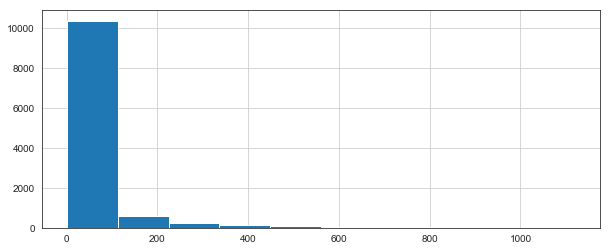

In [127]:
# Graph of ratings column

plt.figure(figsize =(10,4))

movie_rating_counts['number_ratings'].hist(bins = 10)

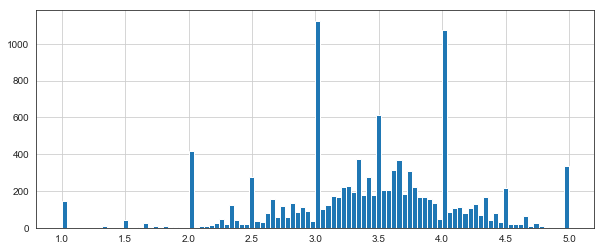

In [128]:
# plot graph of ratings column
plt.figure(figsize = (10,4))

movie_rating_counts['rating'].hist(bins = 100)

In [129]:
# method to make y-axis more readable
def human(num, units = 'M'):
    units = units.lower()
    num = float(num)
    if units == 'k':
        return str(num/10**3) + " K"
    elif units == 'm':
        return str(num/10**6) + " M"
    elif units == 'b':
        return str(num/10**9) +  " B"

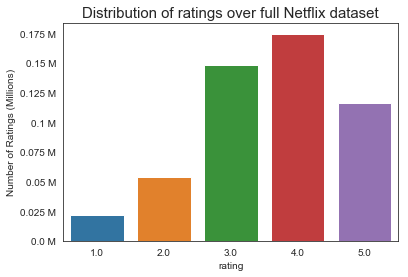

In [130]:
fig, ax = plt.subplots()
plt.title('Distribution of ratings over full Netflix dataset', fontsize=15)
sns.countplot(full_netflix_data.rating)
ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])
ax.set_ylabel('Number of Ratings (Millions)')

plt.show()

In [131]:
rated_movies_per_user = full_netflix_data.groupby(by='user_id')['rating'].count().sort_values(ascending=False)

rated_movies_per_user.head()

user_id
974174     2407
760481     2317
1737529    2068
1486501    2036
1835511    1940
Name: rating, dtype: int64

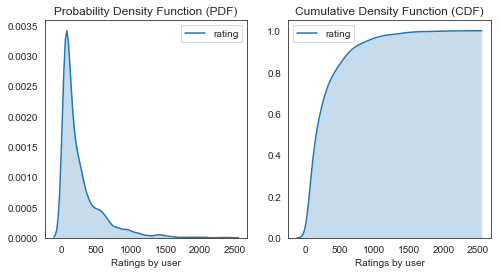

In [132]:
# How do we best mathematically describe (and visually display) random variables? 
# The answer is we use probability density functions (PDF) and cumulative density functions (CDF). 
# CDFs are simpler to comprehend for both discrete and continuous random variables than PDFs.

fig = plt.figure(figsize=plt.figaspect(.5))

ax1 = plt.subplot(121)
sns.kdeplot(rated_movies_per_user, shade=True, ax=ax1)
plt.xlabel('Ratings by user')
plt.title("Probability Density Function (PDF)")

ax2 = plt.subplot(122)
sns.kdeplot(rated_movies_per_user, shade=True, cumulative=True,ax=ax2)
plt.xlabel('Ratings by user')
plt.title('Cumulative Density Function (CDF)')

plt.show()

In [133]:
rated_movies_per_user.describe()

count    1934.000000
mean      265.955533
std       301.296038
min        31.000000
25%        65.000000
50%       150.000000
75%       344.500000
max      2407.000000
Name: rating, dtype: float64

In [134]:
quantiles = rated_movies_per_user.quantile(np.arange(0,1.01,0.01), interpolation='higher')

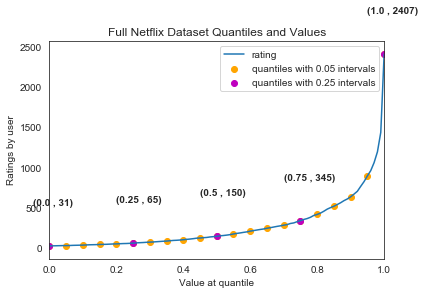

In [135]:
plt.title("Full Netflix Dataset Quantiles and Values")
quantiles.plot()
# quantiles with 0.05 difference
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='m', label = "quantiles with 0.25 intervals")
plt.ylabel('Ratings by user')
plt.xlabel('Value at quantile')
plt.legend(loc='best')

# annotate the 25th, 50th, 75th and 100th percentile values....
for x,y in zip(quantiles.index[::25], quantiles[::25]):
    plt.annotate(s="({} , {})".format(x,y), xy=(x,y), xytext=(x-0.05, y+500)
                ,fontweight='bold')


plt.show()

In [136]:
quantiles[::5]

0.00      31
0.05      35
0.10      41
0.15      49
0.20      56
0.25      65
0.30      78
0.35      91
0.40     108
0.45     129
0.50     150
0.55     179
0.60     214
0.65     250
0.70     288
0.75     345
0.80     421
0.85     523
0.90     640
0.95     899
1.00    2407
Name: rating, dtype: int64

In [137]:
print('\n Ratings at last 5 percentile : {}\n'.format(sum(rated_movies_per_user>= 923)))


 Ratings at last 5 percentile : 90



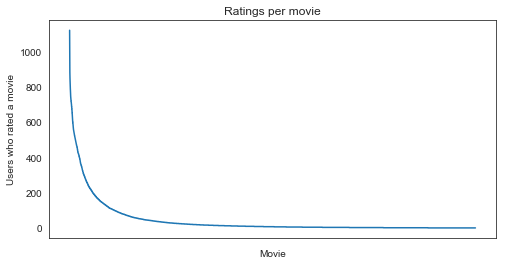

In [138]:
ratings_per_movie = full_netflix_data.groupby(by='movie_id')['rating'].count().sort_values(ascending=False)

fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(ratings_per_movie.values)
plt.title('Ratings per movie')
plt.xlabel('Movie')
plt.ylabel('Users who rated a movie')
ax.set_xticklabels([])

plt.show()

In [139]:
#sort values based on the number of rating column

movie_piv = full_netflix_data_dummy.pivot_table(index = 'user_id', columns = 'movie_title', values = 'rating')

movie_piv.head(5)

movie_rating_counts.sort_values('number_ratings', ascending = False).head(5)

,rating,number_ratings
movie_title,,
Miss Congeniality,3.333333,1119
The Godfather,4.366105,1068
Independence Day,3.709280,1056
Pirates of the Caribbean: The Curse of the Black Pearl,4.150301,998
The Patriot,3.687437,995


In [140]:
# Analysing correlation with similar movies
misscongeniality_user_ratings = movie_piv['Miss Congeniality']
thegodfather_user_ratings = movie_piv['The Godfather']

misscongeniality_user_ratings.head()

user_id
915      NaN
5017     NaN
5583     3.0
13445    5.0
15947    NaN
Name: Miss Congeniality, dtype: float64

In [141]:
thegodfather_user_ratings.head()

user_id
915      NaN
5017     NaN
5583     4.0
13445    NaN
15947    NaN
Name: The Godfather, dtype: float64

In [142]:
# Analyzing the correlation with similar movies
similar_to_misscongeniality = movie_piv.corrwith(misscongeniality_user_ratings)

corr_misscongeniality = pd.DataFrame(similar_to_misscongeniality, columns = ['Correlation'])
corr_misscongeniality.dropna(inplace = True)
corr_misscongeniality.head(10)

,Correlation
movie_title,
'Allo 'Allo!: Series 1,1.000000
'N Sync: 'N the Mix,1.000000
'Round Midnight,-0.258199
...And Justice for All,0.177193
.hack//Legend of the Twilight,0.962250
.hack//SIGN,0.000000
10,-0.398496
10 Things I Hate About You,0.364987
10 to Midnight,1.000000


In [143]:
# Similar movies like Miss Congeniality
corr_misscongeniality.sort_values('Correlation', ascending = False).head(10)
corr_misscongeniality = corr_misscongeniality.join(movie_rating_counts['number_ratings'])
corr_misscongeniality.head()
corr_misscongeniality[corr_misscongeniality['number_ratings']>100].sort_values('Correlation', ascending = False).head()


,Correlation,number_ratings
movie_title,,
Miss Congeniality,1.000000,1119
Dr. Dolittle,0.573629,286
Save the Last Dance,0.542196,173
Two Weeks Notice,0.534179,734
Look Who's Talking Now,0.526742,101


In [144]:
# Analyzing the correlation with similar movies
similar_to_thegodfather = movie_piv.corrwith(thegodfather_user_ratings)

corr_thegodfather = pd.DataFrame(similar_to_thegodfather, columns = ['Correlation'])
corr_thegodfather.dropna(inplace = True)
corr_thegodfather.head(10)

,Correlation
movie_title,
'Round Midnight,0.549350
...And Justice for All,0.094734
.hack//SIGN,1.000000
10,0.585043
10 Things I Hate About You,-0.010355
10 to Midnight,-1.000000
10.5,0.753080
100 Girls,-0.349801
100 Years of Horror,0.500000


In [145]:
# Similar movies like Miss Congeniality
corr_thegodfather.sort_values('Correlation', ascending = False).head(10)
corr_thegodfather = corr_thegodfather.join(movie_rating_counts['number_ratings'])
corr_thegodfather.head()
corr_thegodfather[corr_thegodfather['number_ratings']>100].sort_values('Correlation', ascending = False).head()

,Correlation,number_ratings
movie_title,,
The Godfather,1.000000,1068
American Graffiti: Collector's Edition,0.508794,119
The Sopranos: Season 2,0.444858,196
National Security,0.426002,122
Casino: 10th Anniversary Edition,0.424125,198


In [ ]:
#Another Approach to collaborative filtering

In [146]:
#Collaborative filtering

# Import train_test_split function
from sklearn.model_selection import train_test_split

# Assign X as the original ratings dataframe and y as the Cust_id column of ratings
X = full_netflix_data.copy()
y = full_netflix_data['user_id']

# Split into training and test datasets, stratified along Cust-id
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

# Import the mean_squared_error function
from sklearn.metrics import mean_squared_error

# Function computes the root mean squared error (RMSE)
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Define the base model to always return 3 - middle of the ratings
def baseline(user_id, movie_id):
    return 3.0

# Function to compute the RMSE score obtained on the testing data set by the model
def score(collab_filter_model):
    
    # Construct a list of customer-movie tuples from the testing dataset
    id_cust_movie = zip(X_test['user_id'], X_test['movie_id'])
    
    # Predict the rating for every customer - movie tuple
    y_pred = np.array([collab_filter_model(customer, movie) for (customer, movie)in id_cust_movie])
    
    # Extract the actual ratings given by the customers in the test dataset
    y_true = np.array(X_test['rating'])
    
    # Return the final RMSE score
    return rmse(y_true, y_pred)

In [147]:
score(baseline)

1.2288651882237587

In [148]:
# Ratings Matrix
# Build the ratings matrix using the pivot_table functionality
ratings_matrix = X_train.pivot_table(values='rating', index='user_id', columns='movie_id')

ratings_matrix.head(5)

movie_id,1,3,5,6,8,12,15,16,17,18,...,17758,17760,17761,17762,17763,17764,17765,17766,17768,17769
user_id,,,,,,,,,,,,,,,,,,,,,
915,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5583,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13445,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15947,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [149]:
# Set the null / NaN ratings in the mean_ratings matrix to zero
mean_ratings = ratings_matrix.copy().fillna(0)
mean_ratings_sparse = csr_matrix(mean_ratings.values)
mean_ratings = mean_ratings_sparse

In [150]:
#Mean

# Customer based collaborative filtering using mean ratings
def collab_filter_mean(user_id, movie_id):
    
    
    # Check to see if Movie_id exists in ratings_matrix
    if movie_id in ratings_matrix:
        
        # Compute the mean of all the ratings given to the movie by the customers
        mean_ratings = ratings_matrix[movie_id].mean()
        
    else:
        
        # Default to a rating of 3.0 in the absense of any information
        mean_ratings = 3.0
        
    return mean_ratings  

In [151]:
# Compute RMSE for the Mean model
score(collab_filter_mean)

1.0132790590565257

In [152]:
# Weighted Mean - Another approach to collaborative filtering
# Create a dummy ratings matrix with all null values imputed to 0
ratings_matrix_dummy = ratings_matrix.copy().fillna(0)

ratings_matrix_dummy.head(5)


movie_id,1,3,5,6,8,12,15,16,17,18,...,17758,17760,17761,17762,17763,17764,17765,17766,17768,17769
user_id,,,,,,,,,,,,,,,,,,,,,
915,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13445,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15947,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [153]:
# Import cosine_score
from sklearn.metrics.pairwise import cosine_similarity

# Compute the cosine similarity matrix using the dummy ratings matrix
cosine_similar = cosine_similarity(ratings_matrix_dummy, ratings_matrix_dummy)

In [154]:
# Convert into pandas dataframe
cosine_similar = pd.DataFrame(cosine_similar, index=ratings_matrix.index, columns=ratings_matrix.index)

cosine_similar.head(5)

user_id,915,5017,5583,13445,15947,17344,17530,19661,22816,22846,...,2628705,2629996,2633928,2634908,2638144,2638639,2640401,2642331,2645882,2646192
user_id,,,,,,,,,,,,,,,,,,,,,
915,1.000000,0.000000,0.090442,0.177938,0.055944,0.000000,0.081473,0.000000,0.000000,0.000000,...,0.000000,0.018166,0.000000,0.000000,0.011908,0.000000,0.024581,0.010414,0.033729,0.000000
5017,0.000000,1.000000,0.078475,0.169038,0.116453,0.048858,0.102435,0.074632,0.019519,0.125185,...,0.138749,0.158273,0.000000,0.056598,0.056248,0.050974,0.146075,0.133298,0.181466,0.017945
5583,0.090442,0.078475,1.000000,0.109242,0.076476,0.136392,0.087591,0.126836,0.086583,0.122987,...,0.230484,0.265213,0.080079,0.091953,0.242297,0.102512,0.195368,0.113077,0.094947,0.090021
13445,0.177938,0.169038,0.109242,1.000000,0.133279,0.040829,0.159606,0.088353,0.035270,0.097717,...,0.118941,0.160147,0.009885,0.029824,0.052760,0.039525,0.239808,0.145546,0.143590,0.038165
15947,0.055944,0.116453,0.076476,0.133279,1.000000,0.031100,0.287426,0.193361,0.020310,0.028823,...,0.034207,0.068336,0.000000,0.008076,0.019635,0.074648,0.090416,0.084540,0.058098,0.102571


In [155]:
export_csv = cosine_similar.to_csv (r'C:\Users\AaronDataScienceComp\Documents\export_cosine_similar.csv', index = None, header=True)

export_csv

In [156]:
# User based collaborative filtering using weighted mean ratings
def collab_filter_cust_wmean(user_id, movie_id):
    
    # Check to see if Movie_id exists in ratings_matrix
    if movie_id in ratings_matrix_dummy:
        
        # Pull similarity scores for the customer in question with every other customer
        similar_scores = cosine_similar[user_id]
        
        # Pull the customer ratings for the movie in question
        movie_ratings = ratings_matrix_dummy[movie_id]
        
        # Extract the indices containing NaN in the moving_ratings series
        idx = movie_ratings[movie_ratings.isnull()].index
        
        # Drop the NaN values from the movie_ratings
        movie_ratings = movie_ratings.dropna()
        
        # Drop the corresponding cosine scores from the similar_scores series
        similar_scores = similar_scores.drop(idx)
        
        # Compute the final weighted mean
        wmean_rating = np.dot(similar_scores, movie_ratings) / similar_scores.sum()
        
    else:
        
        # Default to a rating of 3.0 which is the middle of ratings in the absence of any other information
        
        wmean_rating = 3.0
    
    return wmean_rating 

In [157]:
score(collab_filter_cust_wmean) #dataset is still too large - NaNs were taken out - so this approach won't work

# Too computationally expensive for such a data set which makes sense - weighted mean has a lot of calculations in it

3.226075438967756